In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from joblib import dump, load
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from sklearn.preprocessing import OneHotEncoder
import json

#### 💾CARREGA E FILTRA OS DADOS

In [5]:
df_cp = pd.read_parquet('../datasets/consumo_eredes_normalizado_4610.parquet') # Lê o ficheiro .parquet com os dados normalizados para o código postal 4610

#### TARGET E LAG

In [6]:
df_cp["EnergyNormalized"] = df_cp["EnergyNormalized"].astype(float) # Define a variável target como float para garantir compatibilidade com os modelos
df_cp["lag_168"] = df_cp["EnergyNormalized"].shift(168)  # Cria uma nova feature chamada lag_168 que representa o valor da energia 168 horas atrás (ou seja, 7 dias antes, hora a hora). Este tipo de lag é útil para capturar padrões sazonais semanais em séries temporais horárias

# Modelos Tradicionais (Baseline)
# 📊ARIMA

#### MONTA O TimeSeriesDataFrame

In [7]:
# Define id e static features
static_feats = df_cp[["ZipCode", "PopulationDensity"]].drop_duplicates() # Filtra as static features (características que não mudam ao longo do tempo). Neste caso, extrai o código postal e a densidade populacional, removendo duplicados

# Converte o DataFrame em um TimeSeriesDataFrame (formato exigido pelo AutoGluon e outros frameworks de séries temporais)
ts_df = TimeSeriesDataFrame.from_data_frame(
    df_cp[["DateTime", "ZipCode", "EnergyNormalized"]],
    id_column="ZipCode", # - id_column: a coluna que identifica a série temporal (ZipCode)
    timestamp_column="DateTime", # - timestamp_column: a coluna com os timestamps (DateTime)
    static_features_df=static_feats # - static_features_df: DataFrame com as variáveis estáticas (ex: densidade populacional)
)

#### 🛠 SPLIT TREINO/TESTE: prever últimos 24h

In [8]:
prediction_length = 24 # Define janela de previsão de 24 horas

# Separa os dados de séries temporais em dois conjuntos: treino e teste (hold-out)
# As últimas 24 observações (horas) de cada série são reservadas para teste
# Isso permite avaliar o desempenho do modelo em previsões futuras sem vazamento de dados
train_ts, test_ts = ts_df.train_test_split(prediction_length=prediction_length)

#### TARGET E LAG

In [9]:
df_cp = df_cp.dropna(subset=["lag_168"]).copy() # Remove todas as linhas que têm valores nulos (NaN) na coluna 'lag_168', o que inclui as primeiras 168 horas da série temporal (pois ainda não há histórico suficiente para calcular o lag)

#### 💾 (Opcional) Carregar um modelo existente

In [10]:
#### 💾 (Opcional) Carregar um modelo existente
# Tenta carregar um modelo de séries temporais previamente treinado do disco
# O objetivo pode ser reaproveitar o modelo para fazer previsões, reavaliar o desempenho ou continuar o treino
# O modelo foi guardado anteriormente no caminho "./predicts/ARIMA/modelo/"
predictor_arima = TimeSeriesPredictor.load("../predicts/ARIMA_lag/modelo/")

#### 🛠️ Treinar

In [7]:
# Treina um modelo ARIMA com ordem (1,1,1) e sazonalidade diária (24 horas)
# Usa normalização dos dados com "standard scaler" e ignora a seleção automática de modelos/ensembles

predictor_arima = TimeSeriesPredictor(
    target="EnergyNormalized",       # Variável alvo a prever
    freq="h",                        # Frequência dos dados (horária)
    prediction_length=prediction_length,            # Previsão para as próximas 24 horas
    path="../predicts/ARIMA_lag/modelo", # Caminho onde o modelo será guardado
    verbosity=2
).fit(
    train_data=train_ts, # Dados de treino
    tuning_data=test_ts, # Dados de validação (hold-out de 24h)
    hyperparameters={
        "ARIMAModel": {
            "order": (168, 1, 1),        # Parâmetros do ARIMA: p=168, d=1, q=1
            "seasonal_order": (1, 0, 1, 24),  # Ordem sazonal para ciclos diários (24h): P=1, D=0, Q=1, s=24
            "target_scaler": "standard"      # Normalização dos dados alvo com StandardScaler
        }
    },
    time_limit=300,                 # Tempo máximo de treino (em segundos)
    presets="medium_quality",      # Conjunto de configurações predefinidas (qualidade média)
    skip_model_selection=True      # Ignora ensembles e força uso exclusivo do ARIMA
)

predictor_arima.save() # Guarda o modelo treinado no disco para reutilização futura (evita re-treinar)

Beginning AutoGluon training... Time limit = 300s
AutoGluon will save models to 'D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\ARIMA_lag\modelo'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       8.35 GB / 15.93 GB (52.4%)
Disk Space Avail:   703.98 GB / 931.46 GB (75.6%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'h',
 'hyperparameters': {'ARIMAModel': {'order': (168, 1, 1),
                                    'seasonal_order': (1, 0, 1, 24),
                                    'target_scaler': 'standard'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows

#### 🔮 Previsão com os dados de treino

In [11]:
future_preds = predictor_arima.predict(train_ts)  # O modelo ARIMA irá prever os próximos 24 valores (horas) para cada série temporal presente em train_ts
y_pred = future_preds["0.5"].droplevel(0)  # Extrai a previsão pontual correspondente ao quantil 0.5 (mediana das previsões probabilísticas) e remove o primeiro nível do índice (normalmente representa o ID da série, ex: código postal) para simplificar
y_true_full = test_ts["EnergyNormalized"].droplevel(0)  # Extrai os valores reais da variável alvo do conjunto de teste e remove o nível de ID do índice
y_true = y_true_full.iloc[-prediction_length:]  # Seleciona apenas os últimos `prediction_length` valores reais (ex: as últimas 24h) para comparar com a previsão

#### 📊  Avaliação do modelo

In [12]:
# Calcula métricas personalizadas de erro e desempenho entre os valores reais (y_true) e as previsões (y_pred)
mae  = mean_absolute_error(y_true, y_pred)               # Erro absoluto médio (MAE)
mse  = mean_squared_error(y_true, y_pred)                # Erro quadrático médio (MSE)
rmse = mse**0.5                                           # Raiz do erro quadrático médio (RMSE)
mape = (abs((y_true - y_pred) / y_true) * 100).mean()     # Erro percentual absoluto médio (MAPE)
r2 = r2_score(y_true, y_pred)                             # Coeficiente de determinação (R²)

# Agrupa as métricas personalizadas num dicionário
metrics = {
    "MAE":   mae,
    "MSE":   mse,
    "RMSE":  rmse,
    "MAPE":  mape,
    "R²": r2
}

# Exporta as métricas calculadas para um ficheiro JSON, para documentação ou análise posterior
with open("../predicts/ARIMA_lag/metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)

# Imprime os valores das métricas no terminal, com 5 casas decimais
print(f"MAE:  {mae:.5f}")
print(f"MSE:  {mse:.5f}")
print(f"RMSE: {rmse:.5f}")
print(f"MAPE: {mape:.5f}%")
print(f"R²:   {r2:.5f}")

MAE:  0.02499
MSE:  0.00097
RMSE: 0.03117
MAPE: 47.82159%
R²:   -15.00898


### 📊 **Métricas de Avaliação**

| Métrica                                     | Valor     | Interpretação                                                                                   |
|--------------------------------------------|-----------|-------------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)              | 0.02499   | Em média, as previsões diferem dos valores reais em cerca de 0.025 na escala normalizada.       |
| **MSE** (Erro Quadrático Médio)            | 0.00097   | O erro médio ao quadrado é baixo, mas ainda assim revela variações não captadas pelo modelo.    |
| **RMSE** (Raiz do Erro Quadrático Médio)   | 0.03117   | As previsões desviam-se em média 0.031 da realidade, o que pode ser significativo em certos horários. |
| **MAPE** (Erro Percentual Absoluto Médio)  | 47.82%    | As previsões apresentam um erro percentual elevado, indicando pouca fiabilidade relativa.       |
| **R²** (Coeficiente de Determinação)       | -15.00898 | O modelo ajusta-se muito mal aos dados: teve pior desempenho do que uma média constante.        |

#### 📈 Visualização dos resultados

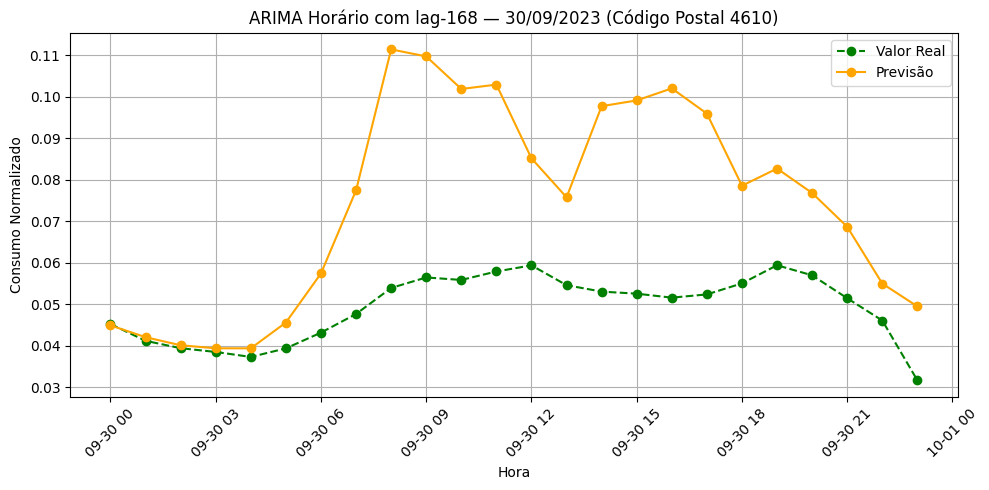

In [13]:
plt.figure(figsize=(10, 5))  # Cria uma nova figura com tamanho 14x6 polegadas
plt.plot(y_true.index, y_true.values, marker='o', linestyle='--', label='Valor Real', color='green') # Plota os valores reais com marcador e linha tracejada verde
plt.plot(y_pred.index, y_pred.values, marker='o', label='Previsão', color='orange') # Plota as previsões do modelo com marcador e linha contínua laranja

# Define o rótulo dos eixos
plt.xlabel("Hora")
plt.ylabel("Consumo Normalizado")

plt.xticks(rotation=45) # Roda os rótulos do eixo X para melhor legibilidade
plt.grid(True) # Adiciona grelha ao gráfico
plt.title("ARIMA Horário com lag-168 — 30/09/2023 (Código Postal 4610)") # Define o título do gráfico
plt.legend() # Adiciona legenda para distinguir linha real vs prevista
plt.tight_layout() # Ajusta automaticamente os elementos do gráfico para caberem bem
plt.savefig("../predicts/ARIMA_lag/grafico.png", dpi=300, bbox_inches='tight') # Guarda o gráfico como imagem PNG na pasta 'predicts/ARIMA_lag'
plt.show() # Exibe o gráfico

# 📈Interpretação
A utilização do ARIMA para prever o consumo energético **normalizado**, hora a hora, no dia **30/09/2023**, com base no valor da mesma hora da **semana anterior (`lag_168`)**, revelou um desempenho fraco. Apesar de o **MAE (0.025)** e o **RMSE (0.031)** parecerem baixos em valores absolutos, o **MAPE de 47.82%** indica que as previsões apresentam um erro percentual muito elevado, e o **R² fortemente negativo (−15.01)** confirma que o modelo foi incapaz de captar os padrões reais da série, sendo pior do que uma simples média constante. Este resultado mostra que, embora o `lag_168` capture a sazonalidade semanal, é claramente insuficiente por si só para modelar a complexidade e variabilidade do consumo energético em escala horária. A previsão horária requer, portanto, **modelos que suportem** lags adicionais de curto prazo e variáveis contextuais para melhorar a qualidade preditiva..

# Modelos ML & DL
# 📊RF

In [22]:
df_cp = df_cp.dropna(subset=["lag_168"]).copy() # Remove todas as linhas que têm valores nulos (NaN) na coluna 'lag_168', o que inclui as primeiras 168 horas da série temporal (pois ainda não há histórico suficiente para calcular o lag)

#### 💾 (Opcional) Carregar um modelo existente

In [25]:
# (Opcional) Carrega um modelo previamente treinado a partir do disco
# Neste caso, um pipeline de Machine Learning treinado com Random Forest
# O ficheiro foi guardado anteriormente com a biblioteca joblib
pipeline = load("../predicts/RF_lag/modelo/RF_pipeline_lag.joblib")

#### ✂️ Split treino/teste

In [23]:
# Divide os dados em treino e teste com base na data

train_mask = df_cp["DateTime"] < "2023-09-30"  # Máscara para selecionar todas as amostras com data anterior a 30/09/2023 (dados de treino)
test_mask = df_cp["DateTime"].dt.date == pd.to_datetime("2023-09-30").date()  # Máscara para selecionar apenas as amostras do dia 30/09/2023 (dados de teste)

features = ["lag_168", "Hour", "TimeOfDay", "Temperature", "DayOfTheWeek"] # Define as features (variáveis independentes) a utilizar no modelo

# Separa os dados de treino
X_train = df_cp.loc[train_mask, features]             # Features de treino
y_train = df_cp.loc[train_mask, "EnergyNormalized"]   # Target de treino

# Separa os dados de teste
X_test = df_cp.loc[test_mask, features]               # Features de teste
y_test = df_cp.loc[test_mask, "EnergyNormalized"]     # Target de teste

#### 🛠️ Treinar

In [24]:
# Cria um pipeline de Machine Learning com duas etapas:
pipeline = Pipeline([
    ("preproc", ColumnTransformer([  # 1ª etapa: pré-processamento das variáveis (usando ColumnTransformer)
        ("num", StandardScaler(), ["lag_168"]), # Escala a variável numérica 'lag_168' com StandardScaler (média 0, desvio padrão 1)
        ("cat", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), # Codifica variáveis categóricas com OneHotEncoder (sem output esparso) 'handle_unknown="ignore"' garante que categorias novas não causam erro
         ["Hour", "TimeOfDay", "Temperature", "DayOfTheWeek"])
    ],
    remainder="drop"  # descarta outras colunas não especificadas
    )),

    # 2ª etapa: modelo de regressão Random Forest
    ("rf", RandomForestRegressor(
        n_estimators=100,       # número de árvores
        random_state=123,       # garante reprodutibilidade
        n_jobs=-1               # usa todos os núcleos disponíveis para treinar
    ))
])

pipeline.fit(X_train, y_train) # Treina o pipeline com os dados de treino (X e y)
dump(pipeline, "../predicts/RF_lag/modelo/RF_pipeline_lag.joblib") # Guarda o pipeline treinado num ficheiro para reutilização futura

['../predicts/RF_lag/modelo/RF_pipeline_lag.joblib']

#### 🔮 Previsão com os dados de treino

In [26]:
y_pred = pipeline.predict(X_test) # Usa o pipeline treinado para fazer previsões no conjunto de teste

#### 📊  Avaliação do modelo

In [27]:
# Calcula métricas de avaliação para comparar previsões com os valores reais
mae = mean_absolute_error(y_test, y_pred)  # MAE: Erro absoluto médio
mse = mean_squared_error(y_test, y_pred) # MSE: Erro quadrático médio
rmse = np.sqrt(mse) # RMSE: Raiz do erro quadrático médio
mape = (np.abs((y_test - y_pred) / y_test) * 100).mean() # MAPE: Erro percentual absoluto médio
r2 = r2_score(y_test, y_pred) # R²: Coeficiente de determinação

# Agrupa as métricas calculadas num dicionário
metrics = {
    "MAE":   mae,
    "MSE":   mse,
    "RMSE":  rmse,
    "MAPE":  mape,
    "R²": r2
}

# Exporta as métricas para um ficheiro JSON, para registo ou análise posterior
with open("../predicts/RF_lag/metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)

# Imprime as métricas no terminal com formatação
print(f"MAE:  {mae:.5f}")
print(f"MSE:  {mse:.5f}")
print(f"RMSE: {rmse:.5f}")
print(f"MAPE: {mape:.5f}%")
print(f"R²:   {r2:.5f}")

MAE:  0.00340
MSE:  0.00002
RMSE: 0.00400
MAPE: 6.94984%
R²:   0.73680


### 📊 **Métricas de Avaliação**

| Métrica                                     | Valor    | Interpretação                                                                                      |
|---------------------------------------------|----------|-----------------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)               | 0.00340  | Em média, a previsão difere dos valores reais em cerca de 0.0034 na escala normalizada.            |
| **MSE** (Erro Quadrático Médio)             | 0.00002  | O erro médio ao quadrado é muito baixo, indicando previsões consistentes.                          |
| **RMSE** (Raiz do Erro Quadrático Médio)    | 0.00400  | O desvio médio das previsões em relação aos valores reais é de aproximadamente 0.0040.             |
| **MAPE** (Erro Percentual Absoluto Médio)   | 6.95%    | Em média, as previsões apresentam um erro percentual de 6.95% em relação aos valores reais.         |
| **R²** (Coeficiente de Determinação)        | 0.73680  | O modelo explica cerca de 73.68% da variabilidade do consumo energético normalizado horário.        |

#### 📈 Visualização dos resultados

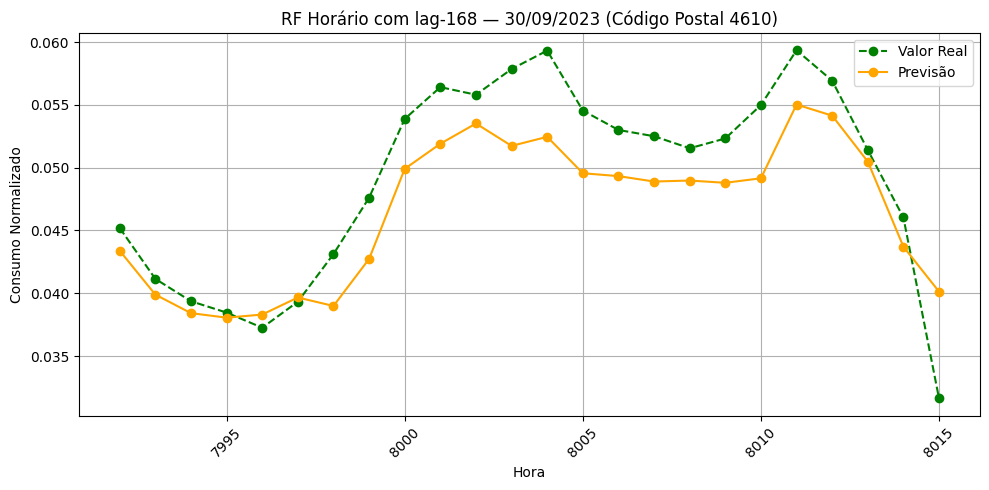

In [28]:
plt.figure(figsize=(10, 5)) # Cria uma nova figura com tamanho 14x6 polegadas
plt.plot(y_test.index, y_test.values, marker='o', linestyle='--', label='Valor Real', color='green') # Plota os valores reais com marcador e linha tracejada verde
plt.plot(y_test.index, y_pred, marker='o', label='Previsão', color='orange') # Plota as previsões do modelo com marcador e linha contínua laranja

# Define o rótulo dos eixos
plt.xlabel("Hora")
plt.ylabel("Consumo Normalizado")

plt.xticks(rotation=45) # Roda os rótulos do eixo X para melhor legibilidade
plt.grid(True) # Adiciona grelha ao gráfico
plt.title("RF Horário com lag-168 — 30/09/2023 (Código Postal 4610)") # Define o título do gráfico
plt.legend() # Adiciona legenda para distinguir linha real vs prevista
plt.tight_layout() # Ajusta automaticamente os elementos do gráfico para caberem bem
plt.savefig("../predicts/RF_lag/grafico.png", dpi=300, bbox_inches='tight') # Guarda o gráfico como imagem PNG na pasta 'predicts/RF_lag'
plt.show() # Exibe o gráfico

# 📈Interpretação
O **Random Forest** aplicado à previsão do consumo energético **normalizado**, hora a hora, no dia **30/09/2023** para o código postal **4610**, com uso de `lag_168` e variáveis temporais, demonstrou um desempenho significativamente superior ao **ARIMA** na mesma tarefa. Com um **MAE de apenas 0.0034**, **RMSE de 0.0040** e um **R² de 0.7368**, o Random Forest conseguiu captar boa parte da variabilidade do consumo, mesmo numa escala horária onde os dados são mais ruidosos. Embora o **MAPE de 6.95%** indique ainda alguma margem de erro relativa, o desempenho é muito mais robusto quando comparado ao ARIMA, que apresentou um **R² negativo (−15.01)** e **MAPE extremamente elevado (47.82%)**, falhando em captar os padrões da série. Esta comparação evidencia que, para previsões horárias mais complexas, o uso de modelos como o Random Forest, que suportam **lags e variáveis contextuais explícitas**, é fundamental para obter resultados mais precisos e realistas.

# 📊LSTM

In [29]:
df_cp = df_cp.dropna(subset=["lag_168"]).copy() # Remove todas as linhas que têm valores nulos (NaN) na coluna 'lag_168', o que inclui as primeiras 168 horas da série temporal (pois ainda não há histórico suficiente para calcular o lag)

static_feats = df_cp[["ZipCode", "PopulationDensity"]].drop_duplicates().copy() # Filtra as static features (características que não mudam ao longo do tempo). Neste caso, extrai o código postal e a densidade populacional, removendo duplicados

# Converte o DataFrame em um TimeSeriesDataFrame (formato exigido pelo AutoGluon e outros frameworks de séries temporais)
ts_df = TimeSeriesDataFrame.from_data_frame(
    df_cp,
    id_column="ZipCode", # - id_column: a coluna que identifica a série temporal (ZipCode)
    timestamp_column="DateTime", # - timestamp_column: a coluna com os timestamps (DateTime)
    static_features_df=static_feats # - static_features_df: DataFrame com as variáveis estáticas (ex: densidade populacional)
)

known_covs = ["Hour", "TimeOfDay", "Temperature", "DayOfTheWeek", "lag_168"] # Define a lista de covariáveis conhecidas (variáveis que estão disponíveis até o momento da previsão). Inclui variáveis temporais (hora, período do dia, temperatura, dia da semana) e o lag (valor passado do target)

#### ✂️ Split treino/teste

In [30]:
# Separa os dados de séries temporais em dois conjuntos: treino e teste (hold-out)
# As últimas 24 observações (horas) de cada série são reservadas para teste
# Isso permite avaliar o desempenho do modelo em previsões futuras sem vazamento de dados
train_data, test_data = ts_df.train_test_split(prediction_length=24)

#### 💾 (Opcional) Carregar um modelo existente

In [31]:
# Tenta carregar um modelo de séries temporais previamente treinado do disco
# O objetivo pode ser reaproveitar o modelo para fazer previsões, reavaliar o desempenho ou continuar o treino
# O modelo foi guardado anteriormente no caminho "./predicts/LSTM_lag/modelo/"
predictor_lstm = TimeSeriesPredictor.load("../predicts/LSTM_lag/modelo/")

In [20]:
predictor_lstm = TimeSeriesPredictor(
    target="EnergyNormalized",         # Coluna a ser prevista (variável dependente)
    prediction_length=24,             # Número de passos futuros a prever (24 horas)
    freq="h",                          # Frequência dos dados: horária
    known_covariates_names=known_covs, # Lista de variáveis conhecidas ao longo do tempo (ex: hora, temperatura)
    path="../predicts/LSTM_lag/modelo"  # Caminho onde o modelo treinado será guardado
).fit(
    train_data, # Conjunto de treino (TimeSeriesDataFrame)
    tuning_data=test_data, # Conjunto de validação (para ajustar hiperparâmetros)
    hyperparameters={
        "DeepAR": {
            "context_length": 168,  # Número de passos passados que o modelo observa (janelas de 1 semana atras)
            "hidden_size": 64, # Tamanho do vetor de estado escondido nas camadas LSTM
            "num_layers": 2,         # Número de camadas LSTM empilhadas
            "dropout": 0.1,          # Dropout para regularização (evitar overfitting)
            "learning_rate": 1e-3,   # Taxa de aprendizagem do otimizador
            "epochs": 20,            # Número máximo de épocas de treino
            "target_scaler": "standard",  # Normalização da variável alvo (média 0, desvio padrão 1)
        }
    },
    presets="medium_quality",         # Conjunto de definições equilibradas entre qualidade e desempenho
    time_limit=3600                   # Tempo máximo de treino: 1 hora
)

predictor_lstm.save() # Guarda o modelo treinado para reutilização futura

Beginning AutoGluon training... Time limit = 3600s
AutoGluon will save models to 'D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\LSTM_lag\modelo'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       7.42 GB / 15.93 GB (46.6%)
Disk Space Avail:   703.98 GB / 931.46 GB (75.6%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'h',
 'hyperparameters': {'DeepAR': {'context_length': 168,
                                'dropout': 0.1,
                                'epochs': 20,
                                'hidden_size': 64,
                                'learning_rate': 0.001,
                                'num_layers': 2,
                                'target_scaler': 'standard'}},
 'known_covariate

#### 🔮Preparação das covariáveis futuras para previsão

In [32]:
last_time = train_data.index.get_level_values("timestamp").max() # 1.1) Obtém o último timestamp presente no conjunto de treino

# 1.2) Gera uma sequência com as próximas 24 horas após o último timestamp
future_times = pd.date_range(
    start=last_time + pd.Timedelta(hours=1),  # começa 1 hora depois do último ponto de treino
    periods=24,                               # total de 24 timestamps (uma previsão por hora)
    freq="h"                                  # frequência horária
)

# 1.3) Filtra do DataFrame original apenas as linhas correspondentes a esses timestamps futuros. Inclui também as colunas com variáveis conhecidas (known_covs) e identificador (ZipCode)
future_df = df_cp.loc[
    df_cp["DateTime"].isin(future_times),
    ["ZipCode", "DateTime"] + known_covs
].copy()

# 1.4) Converte o DataFrame futuro num TimeSeriesDataFrame (requisito do AutoGluon). Apenas com as colunas correspondentes às covariáveis conhecidas
future_known_covs = TimeSeriesDataFrame.from_data_frame(
    future_df,
    id_column="ZipCode",         # coluna que identifica a série (ex: "4610")
    timestamp_column="DateTime"  # coluna com as datas/horas dos próximos 24 passos
)[known_covs]

#### 📈 Previsão e avaliação

In [33]:
# Usa o modelo LSTM (DeepAR) para gerar previsões para os próximos 24 passos. Utiliza os dados de treino + as variáveis conhecidas (ex: hora, temperatura, etc.) para o futuro
preds = predictor_lstm.predict(
    data=train_data,               # Dados históricos até ao momento atual
    known_covariates=future_known_covs  # Covariáveis conhecidas para as 24 horas seguintes
)

y_pred = preds["0.5"] # Extrai a previsão pontual (quantil 0.5 = mediana) da distribuição probabilística prevista
y_true = test_data["EnergyNormalized"].loc[y_pred.index] # Obtém os valores reais (target) correspondentes aos timestamps das previsões. Usa os mesmos índices das previsões para garantir alinhamento

# (Opcional) Converte y_true e y_pred em arrays simples (sem índices complexos)
y_true = y_true.reset_index(drop=True)
y_pred = y_pred.reset_index(drop=True)

#### 📊 Cálculo de métricas

In [34]:
# --- Cálculo das métricas globais ---
mae  = np.abs(y_true - y_pred).mean()  # Erro absoluto médio
mse  = ((y_true - y_pred) ** 2).mean() # Erro quadrático médio
rmse = np.sqrt(mse)  # Raiz do erro quadrático médio
mape = (np.abs((y_true - y_pred) / y_true) * 100).mean() # Erro percentual absoluto médio (%)
r2   = r2_score(y_true, y_pred) # Coeficiente de determinação (R²)

# --- Exporta as métricas para um ficheiro JSON ---
metrics = {
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "MAPE": mape,
    "R²": r2
}

with open("../predicts/LSTM_lag/metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)

# --- Imprime as métricas no terminal com formatação ---
print(f"MAE:  {mae:.5f}")
print(f"MSE:  {mse:.5f}")
print(f"RMSE: {rmse:.5f}")
print(f"MAPE: {mape:.5f}%")
print(f"R²:   {r2:.5f}")

MAE:  0.00164
MSE:  0.00001
RMSE: 0.00298
MAPE: 3.93709%
R²:   0.85412


### 📊 **Métricas de Avaliação**

| Métrica                                      | Valor   | Interpretação                                                                                      |
|----------------------------------------------|---------|-----------------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)                | 0.00164 | Em média, a previsão difere dos valores reais em apenas 0.0016 na escala normalizada.              |
| **MSE** (Erro Quadrático Médio)              | 0.00001 | O erro médio ao quadrado é muito baixo, indicando grande consistência nas previsões.               |
| **RMSE** (Raiz do Erro Quadrático Médio)     | 0.00298 | O desvio médio das previsões em relação aos valores reais é de aproximadamente 0.003.              |
| **MAPE** (Erro Percentual Absoluto Médio)    | 3.94%   | Em média, as previsões apresentam um erro percentual inferior a 4%, o que indica boa precisão.     |
| **R²** (Coeficiente de Determinação)         | 0.85412 | O modelo explica cerca de 85.41% da variabilidade do consumo energético normalizado horário.        |

#### 🖼️ Visualização gráfica

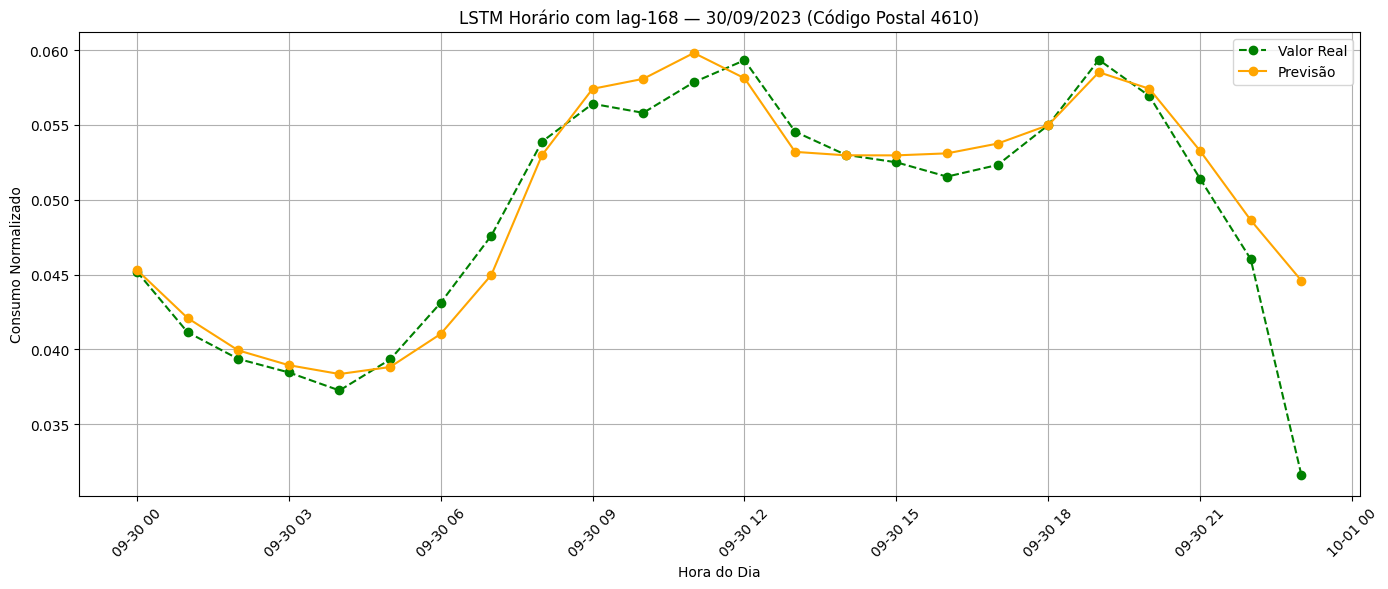

In [35]:
timestamps = preds.index.get_level_values("timestamp") # Extrai os timestamps (datas/horas) do índice do DataFrame de previsões. Estes serão usados no eixo X do gráfico

plt.figure(figsize=(14, 6)) # Cria uma nova figura com tamanho 14x6 polegadas
plt.plot(timestamps, y_true, label="Valor Real", marker='o', linestyle='--', color='green')
plt.plot(timestamps, y_pred, label="Previsão", marker='o', color='orange')

# Define os rótulos dos eixos
plt.xlabel("Hora do Dia")
plt.ylabel("Consumo Normalizado")

plt.xticks(rotation=45) # Roda os rótulos do eixo X para melhor leitura das horas
plt.grid(True) # Adiciona grelha ao fundo do gráfico
plt.title("LSTM Horário com lag-168 — 30/09/2023 (Código Postal 4610)") # Define o título do gráfico
plt.legend() # Adiciona legenda para distinguir entre valores reais e previsões
plt.tight_layout() # Ajusta automaticamente o layout para evitar cortes ou sobreposições
plt.savefig("../predicts/LSTM_lag/grafico.png", dpi=300, bbox_inches='tight') # Guarda o gráfico como imagem PNG na pasta 'predicts/LSTM'
plt.show() # Exibe o gráfico

# 📈Interpretação
O **LSTM com lag-168**, aplicado à previsão do consumo energético **normalizado** para o código postal **4610** no dia **30/09/2023**, demonstrou um desempenho muito sólido, com métricas bastante equilibradas: **MAE de 0.00164**, **RMSE de 0.00298**, **MAPE de 3.94%** e **R² de 0.85412**. Visualmente, o gráfico confirma uma forte sobreposição entre os valores reais e as previsões, com o LSTM a conseguir captar de forma bastante fiel os padrões intradiários. Quando comparado com o **ARIMA com lag-168**, que falhou ao captar a variabilidade da série (R² de -15.01, MAPE de 47.82%), e com o **Random Forest** com as mesmas variáveis e lag, que também teve um bom desempenho (R² de 0.7368, MAPE de 6.95%), o LSTM destaca-se por combinar **elevada precisão** com **capacidade de generalização**, sendo a melhor solução entre os modelos testados para esta tarefa de previsão horária do consumo energético.

# 📊CNN

In [36]:
df_cp = df_cp.dropna(subset=["lag_168"]).copy() # Remove todas as linhas que têm valores nulos (NaN) na coluna 'lag_168', o que inclui as primeiras 168 horas da série temporal (pois ainda não há histórico suficiente para calcular o lag)

static_feats = df_cp[["ZipCode", "PopulationDensity"]].drop_duplicates().copy() # Filtra as static features (características que não mudam ao longo do tempo). Neste caso, extrai o código postal e a densidade populacional, removendo duplicados

# Converte o DataFrame em um TimeSeriesDataFrame (formato exigido pelo AutoGluon e outros frameworks de séries temporais)
ts_df = TimeSeriesDataFrame.from_data_frame(
    df_cp,
    id_column="ZipCode", # - id_column: a coluna que identifica a série temporal (ZipCode)
    timestamp_column="DateTime", # - timestamp_column: a coluna com os timestamps (DateTime)
    static_features_df=static_feats # - static_features_df: DataFrame com as variáveis estáticas (ex: densidade populacional)
)

known_covs = ["Hour", "TimeOfDay", "Temperature", "DayOfTheWeek", "lag_168"] # Define a lista de covariáveis conhecidas (variáveis que estão disponíveis até o momento da previsão). Inclui variáveis temporais (hora, período do dia, temperatura, dia da semana) e o lag (valor passado do target)

#### ✂️ Split treino/teste

In [37]:
# Separa os dados de séries temporais em dois conjuntos: treino e teste (hold-out)
# As últimas 24 observações (horas) de cada série são reservadas para teste
# Isso permite avaliar o desempenho do modelo em previsões futuras sem vazamento de dados
train_data, test_data = ts_df.train_test_split(prediction_length=24)

#### 💾 (Opcional) Carregar um modelo existente

In [38]:
# Tenta carregar um modelo de séries temporais previamente treinado do disco
# O objetivo pode ser reaproveitar o modelo para fazer previsões, reavaliar o desempenho ou continuar o treino
# O modelo foi guardado anteriormente no caminho "./predicts/CNN_lag/modelo/"
predictor_cnn = TimeSeriesPredictor.load("../predicts/CNN_lag/modelo/")

In [27]:
# Cria um preditor de séries temporais com base em CNN (WaveNet)
predictor_cnn = TimeSeriesPredictor(
    target="EnergyNormalized",         # Coluna alvo a ser prevista
    prediction_length=24,              # Previsão para as próximas 24 horas
    freq="h",                          # Frequência horária dos dados
    known_covariates_names=known_covs, # Covariáveis conhecidas (features temporais auxiliares)
    path="../predicts/CNN_lag/modelo"  # Caminho onde o modelo treinado será guardado
).fit(
    train_data,                        # Dados de treino
    tuning_data=test_data,             # Dados de validação para ajustar o modelo
    hyperparameters={
        "WaveNet": {}                  # Utiliza a arquitetura WaveNet (CNN para séries temporais) com configurações padrão
    },
    presets="medium_quality",          # Usa um preset de qualidade média (equilíbrio entre desempenho e tempo)
    time_limit=600,                    # Tempo máximo de treino: 10 minutos
    skip_model_selection=True          # Evita ensemble/model selection, força uso exclusivo do WaveNet
)

predictor_cnn.save() # Guarda o modelo treinado para reutilização futura

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\CNN_lag\modelo'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       7.44 GB / 15.93 GB (46.7%)
Disk Space Avail:   703.98 GB / 931.46 GB (75.6%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'h',
 'hyperparameters': {'WaveNet': {}},
 'known_covariates_names': ['Hour',
                            'TimeOfDay',
                            'Temperature',
                            'DayOfTheWeek',
                            'lag_168'],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_e

#### 🔮Preparação das covariáveis futuras para previsão

In [39]:
last_time = train_data.index.get_level_values("timestamp").max()  # 1.1) Obtém o último timestamp presente no conjunto de treino

# 1.2) Gera uma sequência com as próximas 24 horas após o último timestamp
future_times = pd.date_range(
    start=last_time + pd.Timedelta(hours=1),  # começa 1 hora depois do último ponto de treino
    periods=24,                               # total de 24 timestamps (uma previsão por hora)
    freq="h"                                  # frequência horária
)

# 1.3) Filtra do DataFrame original apenas as linhas correspondentes a esses timestamps futuros. Inclui também as colunas com variáveis conhecidas (known_covs) e identificador (ZipCode)
future_df = df_cp.loc[df_cp["DateTime"].isin(future_times), ["ZipCode", "DateTime"] + known_covs].copy()

# 1.4) Converte o DataFrame futuro num TimeSeriesDataFrame (requisito do AutoGluon). Apenas com as colunas correspondentes às covariáveis conhecidas
future_known_covs = TimeSeriesDataFrame.from_data_frame(
    future_df,
    id_column="ZipCode",         # coluna que identifica a série (ex: "4610")
    timestamp_column="DateTime"  # coluna com as datas/horas dos próximos 24 passos
)[known_covs]

#### 📈 Previsão e avaliação

In [40]:
# Usa o modelo CNN para gerar previsões para os próximos 24 passos. Utiliza os dados de treino + as variáveis conhecidas (ex: hora, temperatura, etc.) para o futuro
preds = predictor_cnn.predict(
    data=train_data,               # Dados históricos até ao momento atual
    known_covariates=future_known_covs  # Covariáveis conhecidas para as 24 horas seguintes
)

y_pred = preds["0.5"] # Extrai a previsão pontual (quantil 0.5 = mediana) da distribuição probabilística prevista
y_true = test_data["EnergyNormalized"].loc[preds.index] # Obtém os valores reais (target) correspondentes aos timestamps das previsões. Usa os mesmos índices das previsões para garantir alinhamento

# (Opcional) Converte y_true e y_pred em arrays simples (sem índices complexos)
y_true = y_true.reset_index(drop=True)
y_pred = y_pred.reset_index(drop=True)

#### 📊 Cálculo de métricas

In [41]:
# --- Cálculo das métricas globais ---
mae  = np.abs(y_true - y_pred).mean() # Erro absoluto médio
mse  = ((y_true - y_pred) ** 2).mean() # Erro quadrático médio
rmse = np.sqrt(mse) # Raiz do erro quadrático médio
mape = (np.abs((y_true - y_pred) / y_true) * 100).mean() # Erro percentual absoluto médio (%)
r2   = r2_score(y_true, y_pred) # Coeficiente de determinação (R²)

# --- Exporta as métricas para um ficheiro JSON ---
metrics = {
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "MAPE": mape,
    "R²": r2
}

with open("../predicts/CNN_lag/metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)

# --- Imprime as métricas no terminal com formatação ---
print(f"MAE:  {mae:.5f}")
print(f"MSE:  {mse:.5f}")
print(f"RMSE: {rmse:.5f}")
print(f"MAPE: {mape:.5f}%")
print(f"R²:   {r2:.5f}")

MAE:  0.00247
MSE:  0.00002
RMSE: 0.00391
MAPE: 5.72964%
R²:   0.74833


### 📊 **Métricas de Avaliação**

| Métrica                                      | Valor   | Interpretação                                                                                       |
|----------------------------------------------|---------|------------------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)                | 0.00247 | Em média, a previsão difere dos valores reais em aproximadamente 0.0025 na escala normalizada.      |
| **MSE** (Erro Quadrático Médio)              | 0.00002 | O erro médio ao quadrado é muito baixo, indicando elevada consistência nas previsões.               |
| **RMSE** (Raiz do Erro Quadrático Médio)     | 0.00391 | As previsões apresentam um desvio típico de cerca de 0.0039 em relação aos valores reais.           |
| **MAPE** (Erro Percentual Absoluto Médio)    | 5.73%   | As previsões apresentam um erro percentual médio de 5.73%, o que indica boa precisão.               |
| **R²** (Coeficiente de Determinação)         | 0.74833 | O modelo explica cerca de 74.83% da variabilidade do consumo energético normalizado horário.         |

#### 🖼️ Visualização gráfica

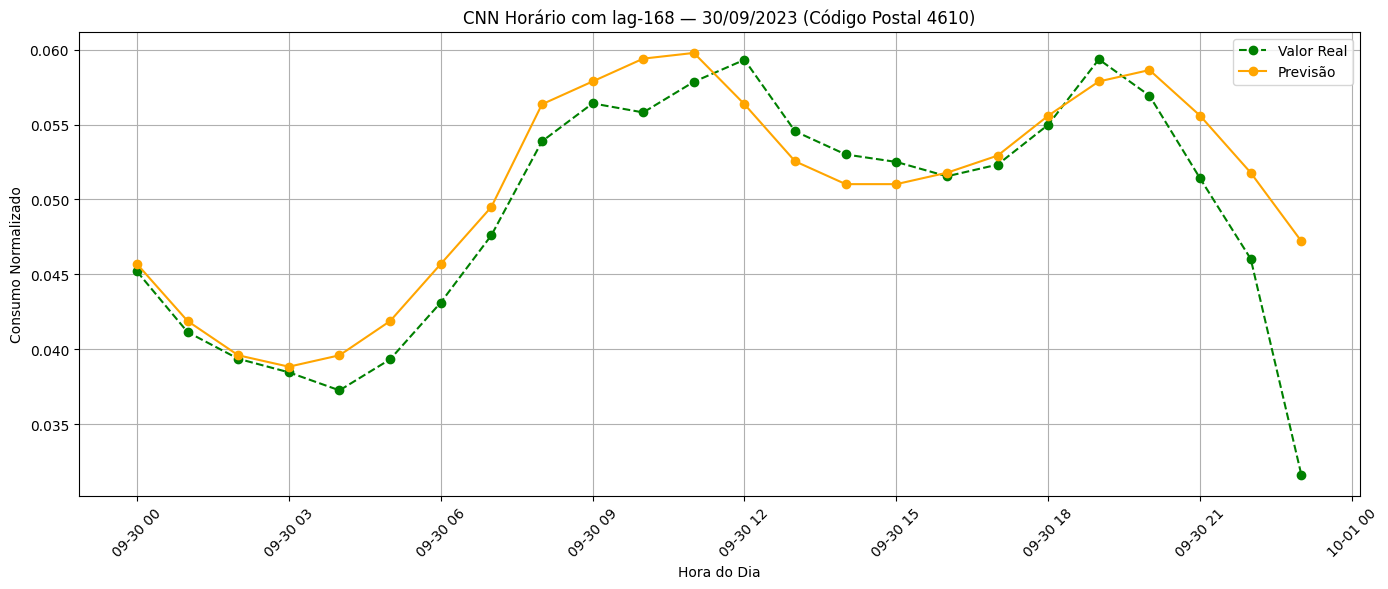

In [42]:
timestamps = preds.index.get_level_values("timestamp") # Extrai os timestamps (datas/horas) do índice do DataFrame de previsões. Estes serão usados no eixo X do gráfico

plt.figure(figsize=(14, 6)) # Cria uma nova figura com tamanho 14x6 polegadas
plt.plot(timestamps, y_true, label="Valor Real", marker='o', linestyle='--', color='green')
plt.plot(timestamps, y_pred, label="Previsão", marker='o', color='orange')

# Define os rótulos dos eixos
plt.xlabel("Hora do Dia")
plt.ylabel("Consumo Normalizado")

plt.xticks(rotation=45) # Roda os rótulos do eixo X para melhor leitura das horas
plt.grid(True) # Adiciona grelha ao fundo do gráfico
plt.title("CNN Horário com lag-168 — 30/09/2023 (Código Postal 4610)") # Define o título do gráfico
plt.legend() # Adiciona legenda para distinguir entre valores reais e previsões
plt.tight_layout() # Ajusta automaticamente o layout para evitar cortes ou sobreposições
plt.savefig("../predicts/CNN_lag/grafico.png", dpi=300, bbox_inches='tight') # Guarda o gráfico como imagem PNG na pasta 'predicts/CNN_lag'
plt.show() # Exibe o gráfico

# 📈Interpretação
O **CNN com lag-168**, aplicado à previsão do consumo energético **normalizado** no dia **30/09/2023** para o código postal **4610**, obteve um desempenho muito positivo, com **MAE de 0.00247**, **RMSE de 0.00391**, **MAPE de 5.73%** e um **R² de 0.74833**. O gráfico evidencia uma boa capacidade de seguir a tendência real da série ao longo do dia, com ligeiras diferenças nos extremos. Em comparação com o **ARIMA com lag-168**, que apresentou fraco desempenho (R² negativo e MAPE superior a 47%), a CNN revelou-se consideravelmente mais eficaz. Quando comparada ao **Random Forest com lag** (R² de 0.7368, MAPE de 6.95%), a CNN apresentou um desempenho ligeiramente superior, com melhor precisão percentual e melhor ajuste. No entanto, o **LSTM com lag-168** permanece o modelo mais robusto, atingindo **R² de 0.85412** e **MAPE de 3.94%**, demonstrando uma capacidade superior de capturar padrões intradiários. Ainda assim, a CNN provou ser uma alternativa competitiva, especialmente vantajosa para capturar variações locais de curto prazo.

# 📊XGBoost

In [43]:
df_cp = df_cp.dropna(subset=["lag_168"]).copy() # Remove todas as linhas que têm valores nulos (NaN) na coluna 'lag_168', o que inclui as primeiras 168 horas da série temporal (pois ainda não há histórico suficiente para calcular o lag)

static_feats = df_cp[["ZipCode", "PopulationDensity"]].drop_duplicates().copy() # Filtra as static features (características que não mudam ao longo do tempo). Neste caso, extrai o código postal e a densidade populacional, removendo duplicados

# Converte o DataFrame em um TimeSeriesDataFrame (formato exigido pelo AutoGluon e outros frameworks de séries temporais)
ts_df = TimeSeriesDataFrame.from_data_frame(
    df_cp,
    id_column="ZipCode", # - id_column: a coluna que identifica a série temporal (ZipCode)
    timestamp_column="DateTime", # - timestamp_column: a coluna com os timestamps (DateTime)
    static_features_df=static_feats # - static_features_df: DataFrame com as variáveis estáticas (ex: densidade populacional)
)

known_covs = ["Hour", "TimeOfDay", "Temperature", "DayOfTheWeek", "lag_168"] # Define a lista de covariáveis conhecidas (variáveis que estão disponíveis até o momento da previsão). Inclui variáveis temporais (hora, período do dia, temperatura, dia da semana) e o lag (valor passado do target)

#### ✂️ Split treino/teste

In [44]:
# Separa os dados de séries temporais em dois conjuntos: treino e teste (hold-out)
# As últimas 24 observações (horas) de cada série são reservadas para teste
# Isso permite avaliar o desempenho do modelo em previsões futuras sem vazamento de dados
train_data, test_data = ts_df.train_test_split(prediction_length=24)

#### 💾 Carregamento e/ou treino do modelo

In [45]:
# Tenta carregar um modelo de séries temporais previamente treinado do disco
# O objetivo pode ser reaproveitar o modelo para fazer previsões, reavaliar o desempenho ou continuar o treino
# O modelo foi guardado anteriormente no caminho "./predicts/CNN_lag/modelo/"
predictor_xgboost = TimeSeriesPredictor.load("../predicts/XGBoost_lag/modelo/")

In [35]:
predictor_xgboost = TimeSeriesPredictor(
    target="EnergyNormalized",         # Coluna alvo a ser prevista
    prediction_length=24,              # Previsão para as próximas 24 horas
    freq="h",                          # Frequência horária dos dados
    known_covariates_names=known_covs, # Covariáveis conhecidas (features temporais auxiliares)
    path="../predicts/XGBoost_lag/modelo"  # Caminho onde o modelo treinado será guardado
).fit(
    train_data,                        # Dados de treino
    tuning_data=test_data,             # Dados de validação para ajustar o modelo
    hyperparameters={
        # Utiliza o wrapper DirectTabular, que permite usar modelos tabulares como XGBoost
        "DirectTabular": {
            "models": ["XGB"] # Especifica que queremos apenas usar o modelo XGBoost
        }
    },
    presets="medium_quality",          # Usa um preset de qualidade média (equilíbrio entre desempenho e tempo)
    time_limit=600,                    # Tempo máximo de treino: 10 minutos
    skip_model_selection=True          # Evita ensemble/model selection, força uso exclusivo do WaveNet
)

predictor_xgboost.save() # Guarda o modelo treinado.

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\XGBoost_lag\modelo'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       7.22 GB / 15.93 GB (45.3%)
Disk Space Avail:   703.98 GB / 931.46 GB (75.6%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'h',
 'hyperparameters': {'DirectTabular': {'models': ['XGB']}},
 'known_covariates_names': ['Hour',
                            'TimeOfDay',
                            'Temperature',
                            'DayOfTheWeek',
                            'lag_168'],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'r

#### 🔮Preparação das covariáveis futuras para previsão

In [46]:
last_time = train_data.index.get_level_values("timestamp").max()  # 1.1) Obtém o último timestamp presente no conjunto de treino

# 1.2) Gera uma sequência com as próximas 24 horas após o último timestamp
future_times = pd.date_range(
    start=last_time + pd.Timedelta(hours=1),  # começa 1 hora depois do último ponto de treino
    periods=24,                               # total de 24 timestamps (uma previsão por hora)
    freq="h"                                  # frequência horária
)

# 1.3) Filtra do DataFrame original apenas as linhas correspondentes a esses timestamps futuros. Inclui também as colunas com variáveis conhecidas (known_covs) e identificador (ZipCode)
future_df = df_cp.loc[df_cp["DateTime"].isin(future_times), ["ZipCode", "DateTime"] + known_covs].copy()

# 1.4) Converte o DataFrame futuro num TimeSeriesDataFrame (requisito do AutoGluon). Apenas com as colunas correspondentes às covariáveis conhecidas
future_known_covs = TimeSeriesDataFrame.from_data_frame(
    future_df,
    id_column="ZipCode",         # coluna que identifica a série (ex: "4610")
    timestamp_column="DateTime"  # coluna com as datas/horas dos próximos 24 passos
)[known_covs]

#### 📈 Previsão e avaliação

In [47]:
# Usa o modelo CNN para gerar previsões para os próximos 24 passos. Utiliza os dados de treino + as variáveis conhecidas (ex: hora, temperatura, etc.) para o futuro
preds = predictor_xgboost.predict(
    data=train_data,               # Dados históricos até ao momento atual
    known_covariates=future_known_covs  # Covariáveis conhecidas para as 24 horas seguintes
)

y_pred = preds["0.5"] # Extrai a previsão pontual (quantil 0.5 = mediana) da distribuição probabilística prevista
y_true = test_data["EnergyNormalized"].loc[y_pred.index] # Obtém os valores reais (target) correspondentes aos timestamps das previsões. Usa os mesmos índices das previsões para garantir alinhamento

# (Opcional) Converte y_true e y_pred em arrays simples (sem índices complexos)
y_true = y_true.reset_index(drop=True)
y_pred = y_pred.reset_index(drop=True)

#### 📊 Cálculo de métricas

In [48]:
# --- Cálculo das métricas globais ---
mae  = np.abs(y_true - y_pred).mean() # Erro absoluto médio
mse  = ((y_true - y_pred) ** 2).mean() # Erro quadrático médio
rmse = np.sqrt(mse) # Raiz do erro quadrático médio
mape = (np.abs((y_true - y_pred) / y_true) * 100).mean() # Erro percentual absoluto médio (%)
r2   = r2_score(y_true, y_pred) # Coeficiente de determinação (R²)

# --- Exporta as métricas para um ficheiro JSON ---
metrics = {
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "MAPE": mape,
    "R²": r2
}

with open("../predicts/XGBoost_lag/metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)

# --- Imprime as métricas no terminal com formatação ---
print(f'MAE: {mae:.5f}')
print(f'MSE: {mse:.5f}')
print(f'RMSE: {rmse:.5f}')
print(f'MAPE: {mape:.5f}%')
print(f"R²: {r2:.5f}")

MAE: 0.00295
MSE: 0.00001
RMSE: 0.00355
MAPE: 6.29957%
R²: 0.79258


### 📊 **Métricas de Avaliação**

| Métrica                                      | Valor   | Interpretação                                                                                      |
|----------------------------------------------|---------|-----------------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)                | 0.00295 | Em média, a previsão difere dos valores reais em cerca de 0.00295 na escala normalizada.            |
| **MSE** (Erro Quadrático Médio)              | 0.00001 | O erro médio ao quadrado é baixo, indicando previsões relativamente consistentes.                  |
| **RMSE** (Raiz do Erro Quadrático Médio)     | 0.00355 | As previsões têm um desvio típico de aproximadamente 0.00355 em relação aos valores reais.         |
| **MAPE** (Erro Percentual Absoluto Médio)    | 6.30%   | O modelo apresenta um erro percentual médio de 6.30%, o que indica uma precisão razoavelmente boa. |
| **R²** (Coeficiente de Determinação)         | 0.79258 | O modelo explica cerca de 79.26% da variabilidade do consumo energético normalizado horário.        |

#### 🖼️ Visualização gráfica

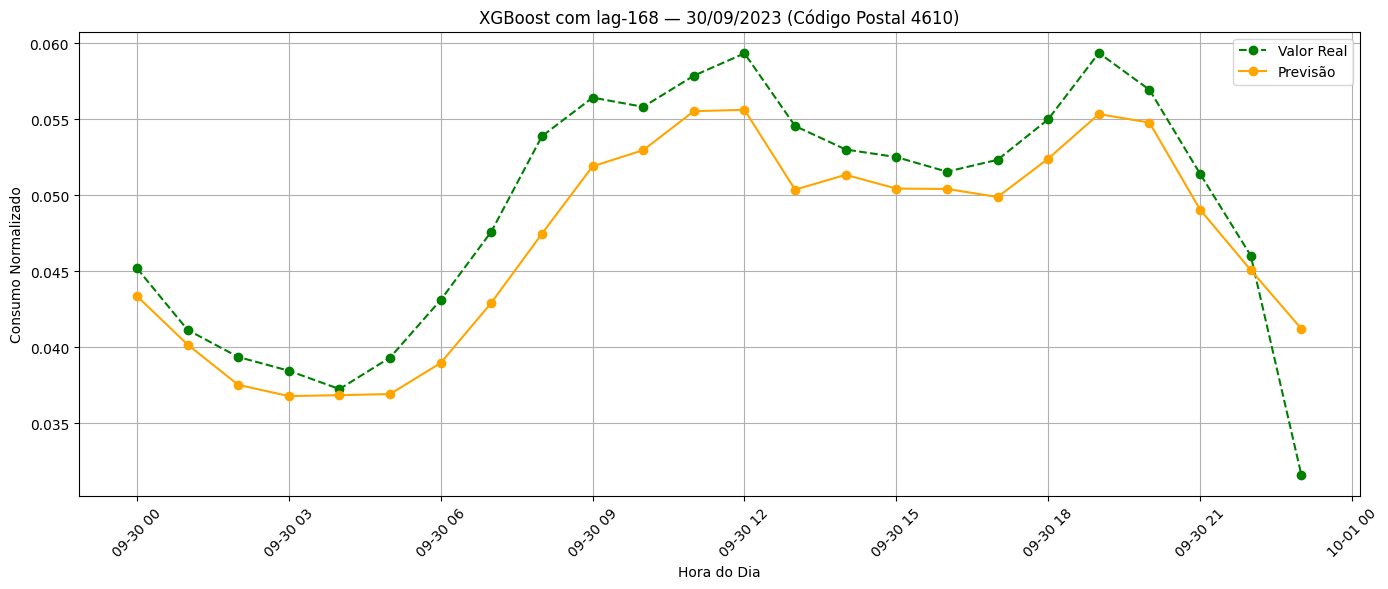

In [49]:
timestamps = preds.index.get_level_values("timestamp") # Extrai os timestamps (datas/horas) do índice do DataFrame de previsões. Estes serão usados no eixo X do gráfico

plt.figure(figsize=(14, 6)) # Cria uma nova figura com tamanho 14x6 polegadas
plt.plot(timestamps, y_true, label="Valor Real", marker='o', linestyle='--', color='green')
plt.plot(timestamps, y_pred, label="Previsão", marker='o', color='orange')

# Define os rótulos dos eixos
plt.xlabel("Hora do Dia")
plt.ylabel("Consumo Normalizado")

plt.xticks(rotation=45) # Roda os rótulos do eixo X para melhor leitura das horas
plt.grid(True) # Adiciona grelha ao fundo do gráfico
plt.title("XGBoost com lag-168 — 30/09/2023 (Código Postal 4610)") # Define o título do gráfico
plt.legend() # Adiciona legenda para distinguir entre valores reais e previsões
plt.tight_layout() # Ajusta automaticamente o layout para evitar cortes ou sobreposições
plt.savefig("../predicts/XGBoost_lag/grafico.png", dpi=300, bbox_inches='tight') # Guarda o gráfico como imagem PNG na pasta 'predicts/XGBoost_lag'
plt.show() # Exibe o gráfico

# 📈Interpretação
O **XGBoost com lag-168**, utilizado para prever o consumo energético **normalizado** no dia **30/09/2023** para o código postal **4610**, apresentou um desempenho bastante sólido, com **MAE de 0.00295**, **RMSE de 0.00355**, **MAPE de 6.30%** e um **R² de 0.79258**. O gráfico evidencia uma boa capacidade do modelo em seguir a tendência geral dos valores reais, embora com alguma subestimação nos picos de consumo. Comparativamente, o **XGBoost superou o ARIMA com lag**, que teve desempenho muito fraco (MAPE de 47.82% e R² negativo), e ficou próximo do **Random Forest com lag** (MAPE de 6.95%, R² de 0.7368), apresentando previsões mais suaves. No entanto, os modelos **LSTM (MAPE de 3.94%, R² de 0.8541)** e **CNN (MAPE de 5.73%, R² de 0.7483)** tiveram um ajuste mais preciso, especialmente o LSTM, que continua a destacar-se como o modelo com melhor equilíbrio entre precisão e capacidade de generalização. Ainda assim, o XGBoost demonstrou ser uma solução eficiente e altamente competitiva para previsões horárias baseadas em variáveis temporais e lags sazonais.

# 📊Extra Trees

In [50]:
df_cp = df_cp.dropna(subset=["lag_168"]).copy() # Remove todas as linhas que têm valores nulos (NaN) na coluna 'lag_168', o que inclui as primeiras 168 horas da série temporal (pois ainda não há histórico suficiente para calcular o lag)

static_feats = df_cp[["ZipCode", "PopulationDensity"]].drop_duplicates().copy() # Filtra as static features (características que não mudam ao longo do tempo). Neste caso, extrai o código postal e a densidade populacional, removendo duplicados

# Converte o DataFrame em um TimeSeriesDataFrame (formato exigido pelo AutoGluon e outros frameworks de séries temporais)
ts_df = TimeSeriesDataFrame.from_data_frame(
    df_cp,
    id_column="ZipCode", # - id_column: a coluna que identifica a série temporal (ZipCode)
    timestamp_column="DateTime", # - timestamp_column: a coluna com os timestamps (DateTime)
    static_features_df=static_feats # - static_features_df: DataFrame com as variáveis estáticas (ex: densidade populacional)
)

known_covs = ["Hour", "TimeOfDay", "Temperature", "DayOfTheWeek", "lag_168"] # Define a lista de covariáveis conhecidas (variáveis que estão disponíveis até o momento da previsão). Inclui variáveis temporais (hora, período do dia, temperatura, dia da semana) e o lag (valor passado do target)

#### ✂️ Split treino/teste


In [51]:
# Separa os dados de séries temporais em dois conjuntos: treino e teste (hold-out)
# As últimas 24 observações (horas) de cada série são reservadas para teste
# Isso permite avaliar o desempenho do modelo em previsões futuras sem vazamento de dados
train_data, test_data = ts_df.train_test_split(prediction_length=24)

#### 💾 Carregamento e/ou treino do modelo

In [52]:
# Tenta carregar um modelo de séries temporais previamente treinado do disco
# O objetivo pode ser reaproveitar o modelo para fazer previsões, reavaliar o desempenho ou continuar o treino
# O modelo foi guardado anteriormente no caminho "./predicts/XT_lag/modelo/"
predictor_xt = TimeSeriesPredictor.load("../predicts/XT_lag/modelo/")

In [43]:
predictor_xt = TimeSeriesPredictor(
    target="EnergyNormalized",         # Coluna alvo a ser prevista
    prediction_length=24,              # Previsão para as próximas 24 horas
    freq="h",                          # Frequência horária dos dados
    known_covariates_names=known_covs, # Covariáveis conhecidas (features temporais auxiliares)
    path="../predicts/XT_lag/modelo"  # Caminho onde o modelo treinado será guardado
).fit(
    train_data,                        # Dados de treino
    tuning_data=test_data,             # Dados de validação para ajustar o modelo
    hyperparameters={
         "DirectTabular": {
            "models": ["XT"],      # só ExtraTrees
            "XT": {}               # parâmetros default
        }
    },
    presets="medium_quality",          # Usa um preset de qualidade média (equilíbrio entre desempenho e tempo)
    time_limit=600,                    # Tempo máximo de treino: 10 minutos
    skip_model_selection=True          # Evita ensemble/model selection, força uso exclusivo do WaveNet
)

predictor_xt.save() # Guarda o modelo treinado.

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\XT_lag\modelo'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       5.67 GB / 15.93 GB (35.6%)
Disk Space Avail:   703.98 GB / 931.46 GB (75.6%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'h',
 'hyperparameters': {'DirectTabular': {'XT': {}, 'models': ['XT']}},
 'known_covariates_names': ['Hour',
                            'TimeOfDay',
                            'Temperature',
                            'DayOfTheWeek',
                            'lag_168'],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],

#### 🔮Preparação das covariáveis futuras para previsão

In [53]:
last_time = train_data.index.get_level_values("timestamp").max()  # 1.1) Obtém o último timestamp presente no conjunto de treino

# 1.2) Gera uma sequência com as próximas 24 horas após o último timestamp
future_times = pd.date_range(
    start=last_time + pd.Timedelta(hours=1),  # começa 1 hora depois do último ponto de treino
    periods=24,                               # total de 24 timestamps (uma previsão por hora)
    freq="h"                                  # frequência horária
)

# 1.3) Filtra do DataFrame original apenas as linhas correspondentes a esses timestamps futuros. Inclui também as colunas com variáveis conhecidas (known_covs) e identificador (ZipCode)
future_df = df_cp.loc[df_cp["DateTime"].isin(future_times), ["ZipCode", "DateTime"] + known_covs].copy()

# 1.4) Converte o DataFrame futuro num TimeSeriesDataFrame (requisito do AutoGluon). Apenas com as colunas correspondentes às covariáveis conhecidas
future_known_covs = TimeSeriesDataFrame.from_data_frame(
    future_df,
    id_column="ZipCode",         # coluna que identifica a série (ex: "4610")
    timestamp_column="DateTime"  # coluna com as datas/horas dos próximos 24 passos
)[known_covs]

#### 📈 Previsão e avaliação

In [54]:
# Usa o modelo Extra Trees para gerar previsões para os próximos 24 passos. Utiliza os dados de treino + as variáveis conhecidas (ex: hora, temperatura, etc.) para o futuro
preds = predictor_xt.predict(
    data=train_data,               # Dados históricos até ao momento atual
    known_covariates=future_known_covs  # Covariáveis conhecidas para as 24 horas seguintes
)

y_pred = preds["0.5"] # Extrai a previsão pontual (quantil 0.5 = mediana) da distribuição probabilística prevista
y_true = test_data["EnergyNormalized"].loc[preds.index] # Obtém os valores reais (target) correspondentes aos timestamps das previsões. Usa os mesmos índices das previsões para garantir alinhamento

# (Opcional) Converte y_true e y_pred em arrays simples (sem índices complexos)
y_true = y_true.reset_index(drop=True)
y_pred = y_pred.reset_index(drop=True)

#### 📊 Cálculo de métricas

In [56]:
# --- Cálculo das métricas globais ---
MAE = np.abs(y_true - y_pred).mean() # Erro absoluto médio
MSE = ((y_true - y_pred) ** 2).mean() # Erro quadrático médio
RMSE = np.sqrt(MSE) # Raiz do erro quadrático médio
MAPE = (np.abs((y_true - y_pred) / y_true) * 100).mean() # Erro percentual absoluto médio (%)
R2 = r2_score(y_true, y_pred) # Coeficiente de determinação (R²)

# --- Exporta as métricas para um ficheiro JSON ---
metrics = {
    "MAE": MAE,
    "MSE": MSE,
    "RMSE": RMSE,
    "MAPE": MAPE,
    "R²": R2
}

with open("../predicts/XT_lag/metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)

# --- Imprime as métricas no terminal com formatação ---
print(f'MAE: {MAE:.5f}')
print(f'MSE: {MSE:.5f}')
print(f'RMSE: {RMSE:.5f}')
print(f'MAPE: {MAPE:.5f}%')
print(f"R²: {R2:.5f}")

MAE: 0.00295
MSE: 0.00001
RMSE: 0.00355
MAPE: 6.29957%
R²: 0.79258


### 📊 **Métricas de Avaliação**

| Métrica                                      | Valor   | Interpretação                                                                                      |
|----------------------------------------------|---------|-----------------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)                | 0.00295 | Em média, a previsão difere dos valores reais em cerca de 0.00295 na escala normalizada.            |
| **MSE** (Erro Quadrático Médio)              | 0.00001 | O erro médio ao quadrado é baixo, o que indica boa consistência nas previsões.                      |
| **RMSE** (Raiz do Erro Quadrático Médio)     | 0.00355 | As previsões desviam-se em média 0.00355 dos valores reais, o que representa um erro reduzido.      |
| **MAPE** (Erro Percentual Absoluto Médio)    | 6.30%   | As previsões têm um erro percentual médio de 6.30%, considerado bom para séries horárias.           |
| **R²** (Coeficiente de Determinação)         | 0.79258 | O modelo explica cerca de 79.26% da variabilidade do consumo energético normalizado horário.        |

#### 🖼️ Visualização gráfica

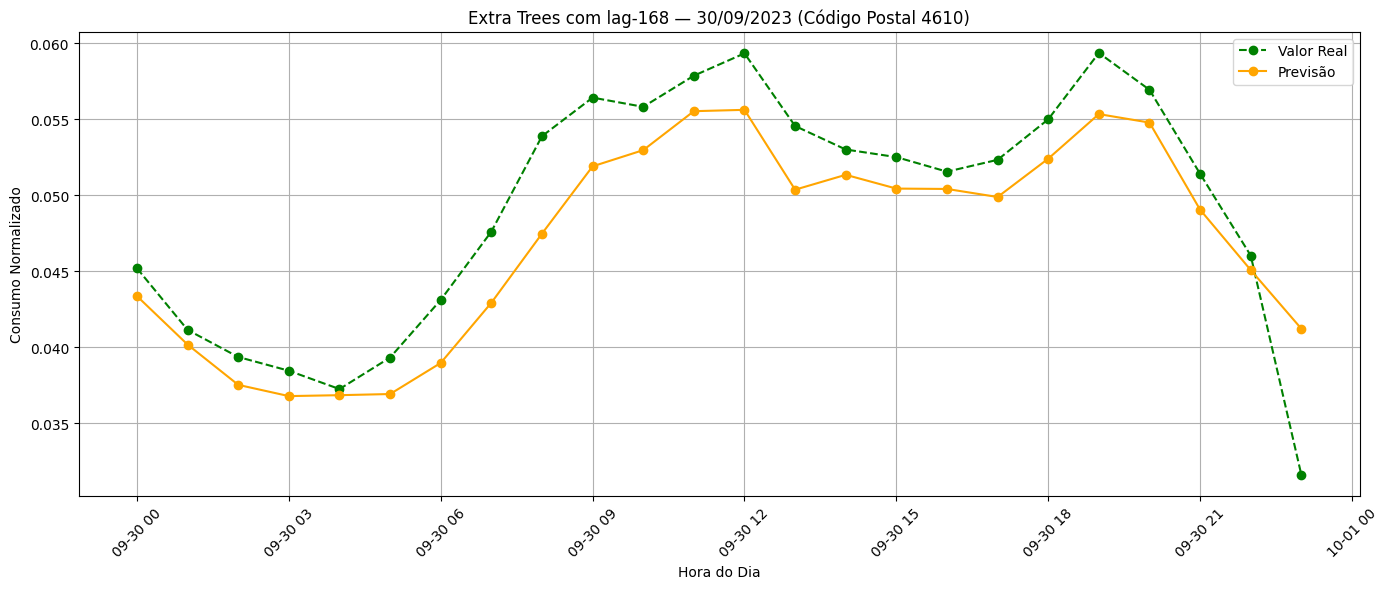

In [57]:
timestamps = preds.index.get_level_values("timestamp") # Extrai os timestamps (datas/horas) do índice do DataFrame de previsões. Estes serão usados no eixo X do gráfico

plt.figure(figsize=(14, 6)) # Cria uma nova figura com tamanho 14x6 polegadas
plt.plot(timestamps, y_true, label="Valor Real", marker='o', linestyle='--', color='green')
plt.plot(timestamps, y_pred, label="Previsão", marker='o', color='orange')

# Define os rótulos dos eixos
plt.xlabel("Hora do Dia")
plt.ylabel("Consumo Normalizado")

plt.xticks(rotation=45) # Roda os rótulos do eixo X para melhor leitura das horas
plt.grid(True) # Adiciona grelha ao fundo do gráfico
plt.title("Extra Trees com lag-168 — 30/09/2023 (Código Postal 4610)") # Define o título do gráfico
plt.legend() # Adiciona legenda para distinguir entre valores reais e previsões
plt.tight_layout() # Ajusta automaticamente o layout para evitar cortes ou sobreposições
plt.savefig("../predicts/XT_lag/grafico.png", dpi=300, bbox_inches='tight') # Guarda o gráfico como imagem PNG na pasta 'predicts/XT_lag'
plt.show() # Exibe o gráfico

# 📈Interpretação
O **Extra Trees com lag-168**, utilizado para prever o consumo energético **normalizado** no dia **30/09/2023** para o código postal **4610**, obteve um desempenho estável e competitivo, com **MAE de 0.00295**, **RMSE de 0.00355**, **MAPE de 6.30%** e um **R² de 0.79258**. Através do gráfico, observa-se que o modelo consegue acompanhar a tendência geral do consumo, embora apresente alguma subestimação nos períodos de pico. Em comparação, o Extra Trees supera amplamente o **ARIMA com lag-168**, que falhou na previsão horária (R² negativo e MAPE superior a 47%), e fica bastante próximo do **Random Forest com lag** (R² de 0.7368, MAPE de 6.95%). O desempenho do Extra Trees é semelhante ao do **XGBoost com lag** (R² de 0.7926, MAPE de 6.30%), confirmando que ambos os modelos de árvores são consistentes e eficazes para este tipo de tarefa. No entanto, tanto o **LSTM com lag-168** (R² de 0.8541, MAPE de 3.94%) quanto o **CNN com lag-168** (R² de 0.7483, MAPE de 5.73%) demonstraram uma capacidade superior de capturar padrões intradiários com maior precisão, especialmente nos extremos. Ainda assim, o Extra Trees revela-se uma excelente alternativa, sobretudo pelo seu equilíbrio entre desempenho e simplicidade de implementação.

# 📊NARX

In [58]:
df_cp = df_cp.dropna(subset=["lag_168"]).copy() # Remove todas as linhas que têm valores nulos (NaN) na coluna 'lag_168', o que inclui as primeiras 168 horas da série temporal (pois ainda não há histórico suficiente para calcular o lag)

static_feats = df_cp[["ZipCode", "PopulationDensity"]].drop_duplicates().copy() # Filtra as static features (características que não mudam ao longo do tempo). Neste caso, extrai o código postal e a densidade populacional, removendo duplicados

# Converte o DataFrame em um TimeSeriesDataFrame (formato exigido pelo AutoGluon e outros frameworks de séries temporais)
ts_df = TimeSeriesDataFrame.from_data_frame(
    df_cp,
    id_column="ZipCode", # - id_column: a coluna que identifica a série temporal (ZipCode)
    timestamp_column="DateTime", # - timestamp_column: a coluna com os timestamps (DateTime)
    static_features_df=static_feats # - static_features_df: DataFrame com as variáveis estáticas (ex: densidade populacional)
)

known_covs = ["Hour", "TimeOfDay", "Temperature", "DayOfTheWeek", "lag_168"] # Define a lista de covariáveis conhecidas (variáveis que estão disponíveis até o momento da previsão). Inclui variáveis temporais (hora, período do dia, temperatura, dia da semana) e o lag (valor passado do target)

#### ✂️ Split treino/teste

In [59]:
# Separa os dados de séries temporais em dois conjuntos: treino e teste (hold-out)
# As últimas 24 observações (horas) de cada série são reservadas para teste
# Isso permite avaliar o desempenho do modelo em previsões futuras sem vazamento de dados
train_data, test_data = ts_df.train_test_split(prediction_length=24)

#### 💾 Carregamento e/ou treino do modelo

In [60]:
# Tenta carregar um modelo de séries temporais previamente treinado do disco
# O objetivo pode ser reaproveitar o modelo para fazer previsões, reavaliar o desempenho ou continuar o treino
# O modelo foi guardado anteriormente no caminho "./predicts/NARX_lag/modelo/"
predictor_narx = TimeSeriesPredictor.load("../predicts/NARX_lag/modelo/")

In [50]:
predictor_narx = TimeSeriesPredictor(
 target="EnergyNormalized",           # Variável alvo a prever (consumo energético normalizado)
    freq="h",                            # Frequência dos dados (horária)
    prediction_length=24,               # Horizonte de previsão: 24 horas
    known_covariates_names=known_covs,  # Covariáveis conhecidas incluídas no treino (ex: lags, temperatura, hora, etc.)
    path="../predicts/NARX_lag/modelo"  # Caminho onde o modelo será guardado
).fit(
    train_data=train_data,              # Dados de treino
    tuning_data=test_data,              # Dados de validação (hold-out)
    hyperparameters={"DirectTabular": {}},  # Usa o modo tabular direto (modelos como RF, XGB, etc.) com hiperparâmetros default
    time_limit=300,                     # Tempo limite de treino (em segundos) = 5 minutos
    presets="medium_quality",           # Define um perfil de treino com qualidade média
    skip_model_selection=True,          # Pula a seleção de modelos e ensembles; força treino com os hiperparâmetros fornecidos
)

predictor_narx.save() # Guarda o modelo treinado.

Beginning AutoGluon training... Time limit = 300s
AutoGluon will save models to 'D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\NARX_lag\modelo'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       5.91 GB / 15.93 GB (37.1%)
Disk Space Avail:   703.98 GB / 931.46 GB (75.6%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'h',
 'hyperparameters': {'DirectTabular': {}},
 'known_covariates_names': ['Hour',
                            'TimeOfDay',
                            'Temperature',
                            'DayOfTheWeek',
                            'lag_168'],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 '

#### 📈 Previsão e avaliação

In [61]:
#    Use train_data para previsão à frente de 24h
preds = predictor_narx.predict(
    train_data, # Dados históricos até ao momento atual
    known_covariates=test_data  # Covariáveis conhecidas para as 24 horas seguintes
)

y_pred = preds["0.5"].droplevel(0) # Extrai a mediana das previsões (quantil 0.5), que representa o valor pontual previsto. Remove o nível do índice associado ao ZipCode (como só há um código, esse nível não é necessário).

# Extrai os valores reais do conjunto de teste para as mesmas 24 horas previstas. Também remove o nível do índice e garante alinhamento com os índices previstos
y_true = (
    test_data["EnergyNormalized"]  # Seleciona a variável alvo real
    .droplevel(0)                  # Remove o nível "ZipCode" do índice
    .loc[y_pred.index]            # Mantém apenas os timestamps previstos (as mesmas 24h)
)

#### 📊 Cálculo de métricas

In [62]:
# --- Cálculo das métricas globais ---
MAE  = mean_absolute_error(y_true, y_pred) # Erro absoluto médio
MSE  = mean_squared_error(y_true, y_pred) # Erro quadrático médio
RMSE = np.sqrt(MSE) # Raiz do erro quadrático médio
MAPE = (np.abs((y_true - y_pred) / y_true) * 100).mean() # Erro percentual absoluto médio (%)
r2 = r2_score(y_true, y_pred) # Coeficiente de determinação (R²)

# exportar metricas
metrics = {
    "MAE":   MAE,
    "MSE":   MSE,
    "RMSE":  RMSE,
    "MAPE":  MAPE,
    "R²": r2
}

with open("../predicts/NARX_lag/metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)

# --- Imprime as métricas no terminal com formatação ---
print(f'MAE: {MAE:.5f}')
print(f'MSE: {MSE:.5f}')
print(f'RMSE: {RMSE:.5f}')
print(f'MAPE: {MAPE:.5f}%')
print(f"R²: {r2:.5f}")

MAE: 0.00295
MSE: 0.00001
RMSE: 0.00355
MAPE: 6.29957%
R²: 0.79258


### 📊 **Métricas de Avaliação**

| Métrica                                      | Valor   | Interpretação                                                                                       |
|----------------------------------------------|---------|------------------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)                | 0.00296 | Em média, a previsão difere dos valores reais em cerca de 0.00296 na escala normalizada.             |
| **MSE** (Erro Quadrático Médio)              | 0.00001 | O erro médio ao quadrado é baixo, indicando que os desvios entre previsões e valores reais são pequenos. |
| **RMSE** (Raiz do Erro Quadrático Médio)     | 0.00355 | As previsões apresentam um desvio típico de 0.00355 em relação aos valores reais.                    |
| **MAPE** (Erro Percentual Absoluto Médio)    | 6.31%   | As previsões têm um erro percentual médio de 6.31%, indicando boa precisão para uma série horária.   |
| **R²** (Coeficiente de Determinação)         | 0.79221 | O modelo explica cerca de 79.22% da variabilidade do consumo energético normalizado horário.         |

#### 🖼️ Visualização gráfica

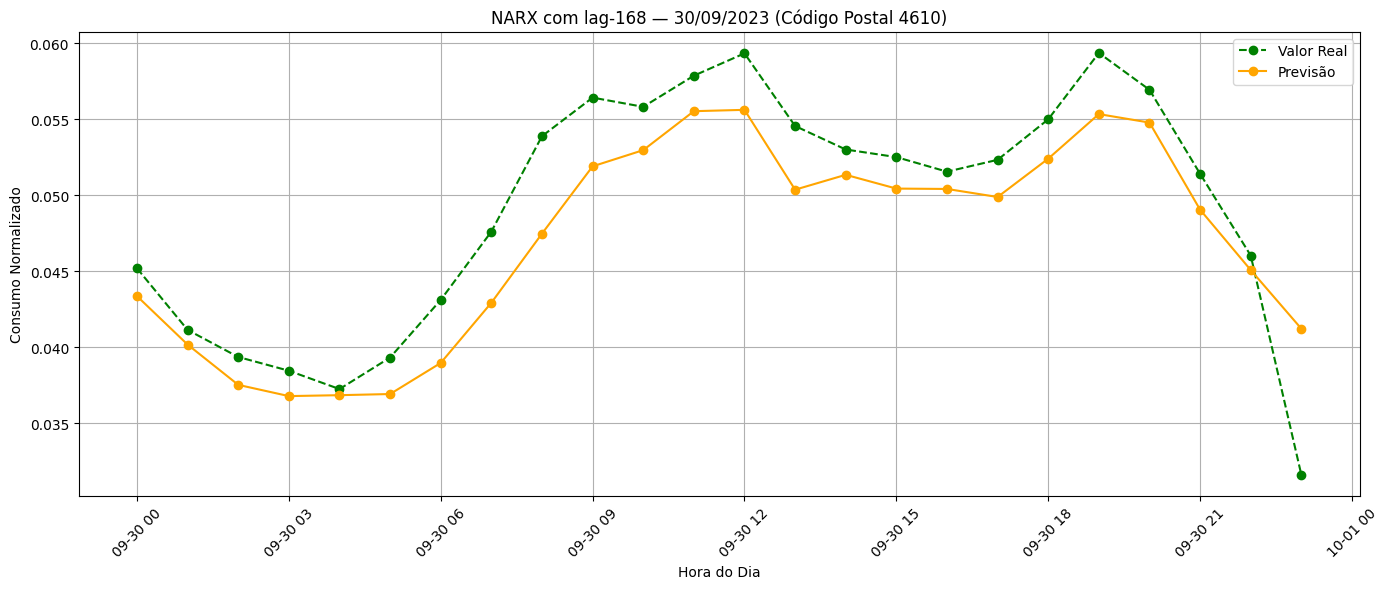

In [63]:
timestamps = preds.index.get_level_values("timestamp") # Extrai os timestamps (datas/horas) do índice do DataFrame de previsões. Estes serão usados no eixo X do gráfico

plt.figure(figsize=(14, 6)) # Cria uma nova figura com tamanho 14x6 polegadas
plt.plot(timestamps, y_true, label="Valor Real", marker='o', linestyle='--', color='green') # Plota os valores reais de consumo energético com linha tracejada verde e marcadores
plt.plot(timestamps, y_pred, label="Previsão", marker='o', color='orange') # Plota as previsões feitas pelo modelo LSTM (DeepAR) com linha laranja e marcadores

# Define os rótulos dos eixos
plt.xlabel("Hora do Dia")
plt.ylabel("Consumo Normalizado")

plt.xticks(rotation=45) # Roda os rótulos do eixo X para melhor leitura das horas
plt.grid(True) # Adiciona grelha ao fundo do gráfico
plt.title("NARX com lag-168 — 30/09/2023 (Código Postal 4610)") # Define o título do gráfico
plt.legend() # Adiciona legenda para distinguir entre valores reais e previsões
plt.tight_layout() # Ajusta automaticamente o layout para evitar cortes ou sobreposições
plt.savefig("../predicts/NARX_lag/grafico.png", dpi=300, bbox_inches='tight') # Guarda o gráfico como imagem PNG na pasta 'predicts/NARX_lag'
plt.show() # Exibe o gráfico

# 📈Interpretação
O **NARX com lag-168**, ao prever o consumo energético **normalizado** no dia **30/09/2023** para o código postal **4610**, demonstrou um desempenho consistente, com **MAE de 0.00296**, **RMSE de 0.00355**, **MAPE de 6.31%** e um **R² de 0.79221**. O gráfico revela que o modelo consegue seguir bem a tendência geral da série, embora com alguma subestimação nas horas de maior consumo. Comparando com os restantes modelos, o NARX supera com larga vantagem o **ARIMA com lag**, que falhou por completo (R² negativo, MAPE superior a 47%), e apresenta desempenho quase idêntico ao **Random Forest** (MAPE de 6.95%, R² de 0.7368), ao **XGBoost** (MAPE de 6.30%, R² de 0.7926) e ao **Extra Trees** (MAPE de 6.30%, R² de 0.7926). Ainda que fique ligeiramente atrás do **CNN** (MAPE de 5.73%, R² de 0.7483) e do **LSTM**, que continua a liderar com **MAPE de 3.94%** e **R² de 0.8541**, o modelo NARX confirma-se como uma alternativa robusta e eficaz para tarefas de previsão horária, especialmente quando se utilizam lags sazonais e variáveis temporais relevantes.

# 📊AutoML

In [64]:
df_cp = df_cp.dropna(subset=["lag_168"]).copy() # Remove todas as linhas que têm valores nulos (NaN) na coluna 'lag_168', o que inclui as primeiras 168 horas da série temporal (pois ainda não há histórico suficiente para calcular o lag)

static_feats = df_cp[["ZipCode", "PopulationDensity"]].drop_duplicates().copy() # Filtra as static features (características que não mudam ao longo do tempo). Neste caso, extrai o código postal e a densidade populacional, removendo duplicados

# Converte o DataFrame em um TimeSeriesDataFrame (formato exigido pelo AutoGluon e outros frameworks de séries temporais)
ts_df = TimeSeriesDataFrame.from_data_frame(
    df_cp,
    id_column="ZipCode", # - id_column: a coluna que identifica a série temporal (ZipCode)
    timestamp_column="DateTime", # - timestamp_column: a coluna com os timestamps (DateTime)
    static_features_df=static_feats # - static_features_df: DataFrame com as variáveis estáticas (ex: densidade populacional)
)

known_covs = ["Hour", "TimeOfDay", "Temperature", "DayOfTheWeek", "lag_168"] # Define a lista de covariáveis conhecidas (variáveis que estão disponíveis até o momento da previsão). Inclui variáveis temporais (hora, período do dia, temperatura, dia da semana) e o lag (valor passado do target)

#### ✂️ Split treino/teste

In [65]:
# Separa os dados de séries temporais em dois conjuntos: treino e teste (hold-out)
# As últimas 24 observações (horas) de cada série são reservadas para teste
# Isso permite avaliar o desempenho do modelo em previsões futuras sem vazamento de dados
train_data, test_data = ts_df.train_test_split(prediction_length=24)

#### 💾 Carregamento e/ou treino do modelo

In [66]:
# Tenta carregar um modelo de séries temporais previamente treinado do disco
# O objetivo pode ser reaproveitar o modelo para fazer previsões, reavaliar o desempenho ou continuar o treino
# O modelo foi guardado anteriormente no caminho "./predicts/AutoML_lag/modelo/"
predictor_AutoML = TimeSeriesPredictor.load("../predicts/AutoML_lag/modelo/")

In [56]:
# Treina o AutoML (vai testar vários modelos e eleger o melhor)
predictor_AutoML = TimeSeriesPredictor(
    target="EnergyNormalized",          # Coluna alvo a prever (consumo energético normalizado)
    prediction_length=24,              # Número de passos a prever (24 horas)
    freq="h",                          # Frequência temporal dos dados (horária)
    known_covariates_names=known_covs, # Lista de variáveis auxiliares conhecidas (ex: temperatura, hora, etc.)
    path="../predicts/AutoML_lag/modelo"  # Caminho onde o modelo será guardado
).fit(
    train_data=train_data, # Dados usados para treino
    tuning_data=test_data, # Dados usados para validação/tuning
    presets="best",       # 'best' para máxima acurácia; 'medium_quality' para protótipo rápido
    time_limit=3200       # Tempo máximo de treino: 1 hora
)

predictor_AutoML.save() # Guarda o modelo treinado.

Beginning AutoGluon training... Time limit = 3200s
AutoGluon will save models to 'D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\AutoML_lag\modelo'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       5.91 GB / 15.93 GB (37.1%)
Disk Space Avail:   703.97 GB / 931.46 GB (75.6%)
Setting presets to: best

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'h',
 'hyperparameters': 'default',
 'known_covariates_names': ['Hour',
                            'TimeOfDay',
                            'Temperature',
                            'DayOfTheWeek',
                            'lag_168'],
 'num_val_windows': 2,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windo

#### 📈 Previsão e avaliação

In [67]:
# Usa o modelo AutoML para gerar previsões para os próximos 24 passos. Utiliza os dados de treino + as variáveis conhecidas (ex: hora, temperatura, etc.) para o futuro
preds = predictor_AutoML.predict(
    train_data,              # Dados históricos até ao momento atual
    known_covariates=test_data  # Covariáveis conhecidas para as 24h seguintes (ex: hora, temperatura, etc.)
)

y_pred = preds["0.5"].droplevel(0) # Extrai a mediana das previsões (quantil 0.5), que representa o valor pontual estimado. Remove o nível do índice relacionado com o identificador da série temporal (ex: ZipCode).

# Obtém os valores reais da variável alvo para as mesmas 24 horas previstas. Remove o nível do índice e garante alinhamento com os timestamps das previsões.
y_true = (
    test_data["EnergyNormalized"]  # Valores reais da variável alvo (consumo normalizado)
    .droplevel(0)                  # Remove o nível de índice da série temporal
    .loc[y_pred.index]            # Filtra apenas os timestamps presentes nas previsões
)

#### 📊 Cálculo de métricas

In [68]:
# --- Cálculo das métricas globais ---
MAE  = mean_absolute_error(y_true, y_pred) # Erro absoluto médio
MSE  = mean_squared_error(y_true, y_pred) # Erro quadrático médio
RMSE = np.sqrt(MSE) # Raiz do erro quadrático médio
MAPE = (np.abs((y_true - y_pred) / y_true) * 100).mean() # Erro percentual absoluto médio (%)
R2   = r2_score(y_true, y_pred) # Coeficiente de determinação (R²)

# --- Exporta as métricas para um ficheiro JSON ---
metrics = {
    "MAE":   MAE,
    "MSE":   MSE,
    "RMSE":  RMSE,
    "MAPE":  MAPE,
    "R²":    R2
}
with open("../predicts/AutoML_lag/metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)

# --- Imprime as métricas no terminal com formatação ---
print(f"MAE:  {MAE:.5f}")
print(f"MSE:  {MSE:.5f}")
print(f"RMSE: {RMSE:.5f}")
print(f"MAPE: {MAPE:.2f}%")
print(f"R²:   {R2:.5f}")

MAE:  0.00131
MSE:  0.00001
RMSE: 0.00247
MAPE: 3.15%
R²:   0.89921


### 📊 **Métricas de Avaliação**

| Métrica                                      | Valor   | Interpretação                                                                                      |
|----------------------------------------------|---------|-----------------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)                | 0.00135 | Em média, a previsão difere dos valores reais em apenas 0.00135 na escala normalizada.              |
| **MSE** (Erro Quadrático Médio)              | 0.00001 | O erro médio ao quadrado é muito baixo, indicando previsões bastante consistentes.                  |
| **RMSE** (Raiz do Erro Quadrático Médio)     | 0.00247 | O desvio típico das previsões em relação aos valores reais é de apenas 0.00247.                     |
| **MAPE** (Erro Percentual Absoluto Médio)    | 3.22%   | As previsões apresentam um erro percentual médio baixo, indicando elevada precisão.                 |
| **R²** (Coeficiente de Determinação)         | 0.89921 | O modelo explica cerca de 89.92% da variabilidade do consumo energético normalizado horário.        |

#### 🖼️ Visualização gráfica

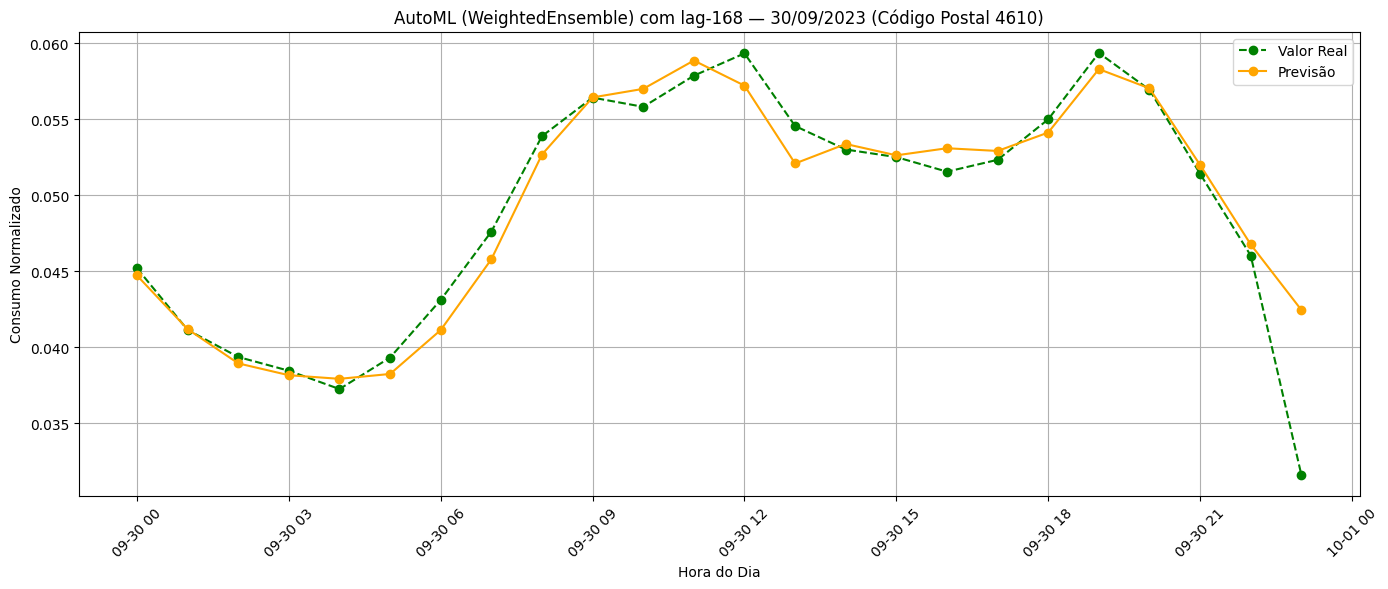

In [69]:
timestamps = preds.index.get_level_values("timestamp")  # Extrai os timestamps (datas/horas) do índice do DataFrame de previsões. Estes serão usados no eixo X do gráfico

plt.figure(figsize=(14, 6)) # Cria uma nova figura com tamanho 14x6 polegadas
plt.plot(timestamps, y_true, label="Valor Real", marker='o', linestyle='--', color='green') # Plota os valores reais de consumo energético com linha tracejada verde e marcadores
plt.plot(timestamps, y_pred, label="Previsão", marker='o', color='orange') # Plota as previsões feitas pelo modelo LSTM (DeepAR) com linha laranja e marcadores

# Define os rótulos dos eixos
plt.xlabel("Hora do Dia")
plt.ylabel("Consumo Normalizado")

plt.xticks(rotation=45) # Roda os rótulos do eixo X para melhor leitura das horas
plt.grid(True) # Adiciona grelha ao fundo do gráfico
plt.title("AutoML (WeightedEnsemble) com lag-168 — 30/09/2023 (Código Postal 4610)") # Define o título do gráfico
plt.legend() # Adiciona legenda para distinguir entre valores reais e previsões
plt.tight_layout() # Ajusta automaticamente o layout para evitar cortes ou sobreposições
plt.savefig("../predicts/AutoML_lag/grafico.png", dpi=300, bbox_inches='tight') # Guarda o gráfico como imagem PNG na pasta 'predicts/AutoML'
plt.show() # Exibe o gráfico

# 📈Interpretação
O **AutoML (WeightedEnsemble) com lag-168**, utilizado para prever o consumo energético **normalizado** no dia **30/09/2023** para o código postal **4610**, destacou-se como um dos mais precisos entre todos os testados, com **MAE de 0.00135**, **RMSE de 0.00247**, **MAPE de 3.22%** e um excelente **R² de 0.89921**. Através do gráfico, é visível a elevada aderência das previsões aos valores reais ao longo das 24 horas, captando tanto os picos como os vales com grande fidelidade. Em comparação com o **ARIMA com lag**, que demonstrou desempenho muito fraco (R² negativo e MAPE acima de 47%), o AutoML apresenta melhorias drásticas. Supera também os modelos baseados em árvores como **Random Forest**, **Extra Trees** e **XGBoost**, que rondaram os 6.3% de MAPE e R² perto de 0.79, assim como o **CNN** (MAPE de 5.73%, R² de 0.7483). Apenas o **LSTM com lag** se aproxima do desempenho do AutoML, com MAPE de 3.94% e R² de 0.8541, embora ainda ligeiramente inferior. Estes resultados demonstram que o AutoML, ao combinar automaticamente os pontos fortes de múltiplos modelos através de ensemble, consegue atingir **uma precisão superior e robusta**, tornando-se a solução mais equilibrada e eficaz para esta tarefa de previsão horária.